In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from random import randint

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.models.image.cifar10 import cifar10

In [2]:
import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

In [3]:
cifar10_dir = '/home/lope/Descargas/cifar-10-batches-py/'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

X_train = X_train / 255.
X_test = X_test/255.

b = np.zeros((y_test.shape[0], 10))
b[np.arange(y_test.shape[0]), y_test] = 1.
y_test = b

b = np.zeros((y_train.shape[0], 10))
b[np.arange(y_train.shape[0]), y_train] = 1.
y_train = b

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

def getBatch(n):
    indexes = np.random.randint(0,X_train.shape[0],size=(n))
    return X_train[indexes], y_train[indexes]

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 10)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 10)


In [4]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [5]:
x = tf.placeholder(tf.float32,[None, 32,32,3])

h = tf.placeholder(tf.float32,[1, 16,16,35])

sty = tf.placeholder(tf.float32, [1,32, 32,3])

y_ = tf.placeholder(tf.float32, [None, 10])

x_image = x

W_conv1 = weight_variable([5, 5, 3, 40])
b_conv1 = bias_variable([40])

W_conv2 = weight_variable([5, 5, 40, 35])
b_conv2 = bias_variable([35])

W_fc1 = weight_variable([8 * 8 * 35, 500])
b_fc1 = bias_variable([500])


h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*35])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 = weight_variable([500, 10])
b_fc2 = bias_variable([10])
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

sh_conv1 = tf.nn.relu(conv2d(sty, W_conv1) + b_conv1)
sh_pool1 = max_pool_2x2(sh_conv1)
sh_conv2 = tf.nn.relu(conv2d(sh_pool1, W_conv2) + b_conv2)
sh_pool2 = max_pool_2x2(sh_conv2)
stemp = tf.reshape(sh_conv1, [32*32,40])
ssty = tf.matmul(tf.transpose(stemp), stemp)

r = tf.Variable(tf.random_normal([1, 32,32,3], stddev=0.1))
rh_conv1 = tf.nn.relu(conv2d(r, W_conv1) + b_conv1)
rh_pool1 = max_pool_2x2(rh_conv1)
rh_conv2 = tf.nn.relu(conv2d(rh_pool1, W_conv2) + b_conv2)
rh_pool2 = max_pool_2x2(rh_conv2)
temp = tf.reshape(rh_conv1, [32*32,40])
rsty = tf.matmul(tf.transpose(temp), temp)
rareLoss = tf.reduce_mean(tf.square(rh_conv2 - h)) + 0.01*tf.reduce_mean(tf.square(rsty - ssty))
rareTrain = tf.train.GradientDescentOptimizer(0.01).minimize(rareLoss, var_list=[r])

saver = tf.train.Saver()

sess = tf.InteractiveSession()

cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess.run(tf.initialize_all_variables())

#for i in range(50000):
#    batch = getBatch(500)
#   
#    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
#    if i%1000 == 0:
#        test = accuracy.eval(feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0})
#        train = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
#        print "step " + str(i) + " score: " + str(test)+" train: "+str(train)        

#print "test accuracy %g"%accuracy.eval(feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0})

In [6]:
#RESTORE!

saver.restore(sess, "/home/lope/model.ckpt")
print("Model restored!")

print "test accuracy %g"%accuracy.eval(feed_dict={ x: X_test[0:1000], y_: y_test[0:1000], keep_prob: 1.0})
#rareTrain = tf.train.AdamOptimizer(0.01).minimize(rareLoss, var_list=[r])

Model restored!
test accuracy 0.699


In [7]:
# Save the variables to disk.
save_path = saver.save(sess, "/home/lope/model.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: /home/lope/model.ckpt


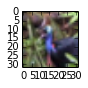

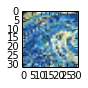

In [10]:
from skimage.io import imread
from skimage.transform import resize
import pylab as pylab
pylab.rcParams['figure.figsize'] = (1.0, 1.0)


n = 24

update = tf.assign(r, np.asarray([X_train[n]]))
sess.run(update)
plt.imshow(X_train[n])
plt.show()

sty_img = resize(imread("starry_night.jpg"), (200,400))[80:112,240:272,:]
plt.imshow(sty_img)
plt.show()

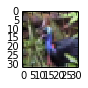

RareLoss: 18.0742


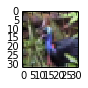

RareLoss: 0.263181


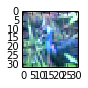

RareLoss: 0.214275


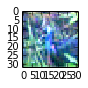

RareLoss: 0.193946


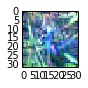

RareLoss: 0.180955


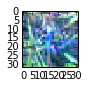

RareLoss: 0.171613


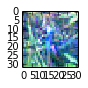

RareLoss: 0.164217


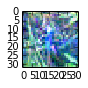

KeyboardInterrupt: 

In [11]:
img = X_train[n]

plt.imshow(img, interpolation="none")
plt.show()
vh = sess.run(h_conv2, feed_dict={x:[X_test[n]], y_:[y_test[n]]})

#rareLoss =  tf.reduce_mean(tf.square(rsty - ssty))
rareTrain = tf.train.GradientDescentOptimizer(0.01).minimize(rareLoss, var_list=[r])


for i in range(50000):
    if i % 5000 == 0:
        print("RareLoss: "+str(sess.run(rareLoss, feed_dict={h: vh, sty: [sty_img]})))
        rimg = sess.run(r)[0]
        
        rimg = np.clip(rimg,0,1)
        update = tf.assign(r, np.asarray([rimg]))
        sess.run(update)
        
        plt.imshow(rimg, interpolation="none")
        plt.show()
        
        
        
    rareTrain.run(feed_dict={h: vh, sty:  [sty_img]})

    
rimg = sess.run(r)[0]
plt.imshow(rimg, interpolation="none")

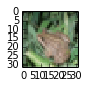

In [35]:
rimg = X_test[4]#sess.run(r)[0]
plt.imshow(rimg, interpolation="none")

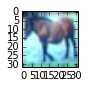

In [22]:
plt.imshow(np.clip(rimg,0,1))